# Residential Rooftop PV Example

## Set up.

### Import packages.

In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath("../../../src"))

In [2]:
import numpy             as np
import matplotlib.pyplot as pl
import pandas            as pd
import re                as re
import scipy.stats       as st
import seaborn           as sb
import tyche             as ty

from copy import deepcopy

## Scenario analyses.

### Load data.

#### The data are stored in a set of tab-separated value files in a folder.

In [3]:
designs = ty.Designs(path = ".",
                    name = 'pv-residential-large.xlsx')

#### Compile the production and metric functions for each technology in the dataset.

In [4]:
designs.compile()

### Examine the data.

#### The `functions` table specifies where the Python code for each technology resides.

In [5]:
designs.functions

,Style,Model,Capital,Fixed,Production,Metrics,Notes
Technology,,,,,,,
PV Generic,numpy,pv_residential_large,capital_cost,fixed_cost,production,metrics,generic residential PV


Right now, only the style `numpy` is supported.

#### The `indices` table defines the subscripts for variables.

In [6]:
designs.indices.sort_values(["Technology", "Type", "Offset"])

Offset               Description Notes
Technology Type    Index                                              
PV Generic Capital Module            0             system module   NaN
                   Inverter          1          system inverters   NaN
                   BoS               2         balance of system   NaN
           Input   Strategic         0       strategic materials   NaN
           Metric  Capital           0              capital cost   NaN
                   LCOE              1  levelized cost of energy   NaN
                   GHG               2      greenouse gas offset   NaN
                   Strategic         3      strategic metal used   NaN
                   Hazardous         4  hazardous waste produced   NaN
                   Yield             5            specific yield   NaN
                   Efficiency        6         module efficiency   NaN
                   Lifetime          7           module lifetime   NaN
           Output  Electricity       0     electricity generated   NaN
                   Hazardous         1  hazardous waste produced   NaN
                   GHG               2     greenhouse gas offset   NaN

#### The `designs` table contains the cost, input, efficiency, and price data for a scenario.

In [7]:
print(designs.designs)

                                                                                      Value  \
Technology Tranche      Variable          Index                                               
PV Generic CIGS 0       Input             Strategic     st.triang(0.5, loc=2520, scale=500)   
                        Input efficiency  Strategic    st.triang(0.5, loc=0.70, scale=0.05)   
                        Input price       Strategic                                       0   
                        Lifetime          BoS                                             1   
                                          Inverter                                        1   
...                                                                                     ...   
           Soft Costs 2 Output efficiency Hazardous                                       1   
                        Output price      Electricity                                     0   
                                          GHG     

In [8]:
designs.designs.xs("CIGS 0", level="Tranche", drop_level=False)

Value  \
Technology Tranche Variable          Index                                               
PV Generic CIGS 0  Input             Strategic     st.triang(0.5, loc=2520, scale=500)   
                   Input efficiency  Strategic    st.triang(0.5, loc=0.70, scale=0.05)   
                   Input price       Strategic                                       0   
                   Lifetime          BoS                                             1   
                                     Inverter                                        1   
                                     Module                                          1   
                   Output efficiency Electricity                                     1   
                                     GHG                                             1   
                                     Hazardous                                       1   
                   Output price      Electricity                                     0   
                                     GHG                                             0   
                                     Hazardous                                       0   
                   Scale             GHG                                             1   

                                                            Units  \
Technology Tranche Variable          Index                          
PV Generic CIGS 0  Input             Strategic           g/system   
                   Input efficiency  Strategic              %/100   
                   Input price       Strategic                $/g   
                   Lifetime          BoS          system-lifetime   
                                     Inverter     system-lifetime   
                                     Module       system-lifetime   
                   Output efficiency Electricity            %/100   
                                     GHG                    %/100   
                                     Hazardous              %/100   
                   Output price      Electricity            $/kWh   
                                     GHG                  $/gCO2e   
                                     Hazardous                $/g   
                   Scale             GHG            system/system   

                                                                                            Notes  
Technology Tranche Variable          Index                                                         
PV Generic CIGS 0  Input             Strategic                                    zero by default  
                   Input efficiency  Strategic                                         no scaling  
                   Input price       Strategic                                    zero by default  
                   Lifetime          BoS                                per-lifetime computations  
                                     Inverter                           per-lifetime computations  
                                     Module                             per-lifetime computations  
                   Output efficiency Electricity  see parameter table for individual efficiencies  
                                     GHG          see parameter table for individual efficiencies  
                                     Hazardous    see parameter table for individual efficiencies  
                   Output price      Electricity                   not tracking electricity price  
                                     GHG                             not tracking hazardous waste  
                                     Hazardous                       not tracking hazardous waste  
                   Scale             GHG                                               no scaling

#### The `parameters` table contains additional techno-economic parameters for each technology.

In [9]:
designs.parameters.xs(
    "CIGS 0", level="Tranche", drop_level=False
).sort_values(
    ["Technology", "Tranche", "Offset"]
)

Offset  \
Technology Tranche Parameter                             
PV Generic CIGS 0  Discount Rate                     0   
                   Insolation                        1   
                   System Size                       2   
                   Module Capital                    3   
                   Module Lifetime                   4   
                   Module Efficiency                 5   
                   Module Aperture                   6   
                   Module O&M Fixed                  7   
                   Module Degradation                8   
                   Location Capacity Factor          9   
                   Module Soiling Loss              10   
                   Inverter Capital                 11   
                   Inverter Lifetime                12   
                   Inverter Replacement             13   
                   Inverter Efficiency              14   
                   Hardware Capital                 15   
                   Direct Labor                     16   
                   Permitting                       17   
                   Customer Acquisition             18   
                   Installer Overhead & Profit      19   
                   Hazardous Waste Content          20   
                   Greenhouse Gas Offset            21   
                   Benchmark LCOC                   22   
                   Benchmark LCOE                   23   

                                                                                 Value  \
Technology Tranche Parameter                                                             
PV Generic CIGS 0  Discount Rate                                                  0.07   
                   Insolation                                                     1000   
                   System Size                                                      36   
                   Module Capital                    st.triang(0.5, loc=250, scale=75)   
                   Module Lifetime                st.triang(0.5, loc=25, scale=0.0025)   
                   Module Efficiency             st.triang(0.5, loc=0.210, scale=0.05)   
                   Module Aperture                 st.triang(0.5, loc=0.9, scale=9e-5)   
                   Module O&M Fixed                st.triang(0.5, loc=20, scale=0.002)   
                   Module Degradation           st.triang(0.5, loc=0.0075, scale=0.05)   
                   Location Capacity Factor        st.triang(0.5, loc=0.2, scale=2e-5)   
                   Module Soiling Loss            st.triang(0.5, loc=0.05, scale=5e-6)   
                   Inverter Capital                st.triang(0.5, loc=0.3, scale=3e-5)   
                   Inverter Lifetime              st.triang(0.5, loc=16, scale=0.0016)   
                   Inverter Replacement            st.triang(0.5, loc=0.5, scale=5e-5)   
                   Inverter Efficiency             st.triang(0.5, loc=0.9, scale=9e-5)   
                   Hardware Capital                st.triang(0.5, loc=80, scale=0.008)   
                   Direct Labor                    st.triang(0.5, loc=2000, scale=0.2)   
                   Permitting                      st.triang(0.5, loc=600, scale=0.06)   
                   Customer Acquisition            st.triang(0.5, loc=2000, scale=0.2)   
                   Installer Overhead & Profit  st.triang(0.5, loc=0.35, scale=3.5e-5)   
                   Hazardous Waste Content           st.triang(0.5, loc=305, scale=10)   
                   Greenhouse Gas Offset                                      0.000449   
                   Benchmark LCOC                                              2.51977   
                   Benchmark LCOE                                             0.086773   

                                                    Units Notes  
Technology Tranche Parameter                                     
PV Generic CIGS 0  Discount Rate                   1/year    DR  


#### The `results` table specifies the units of measure for results of computations.

In [10]:
designs.results

Units Notes
Technology Variable Index                            
PV Generic Cost     Cost               $/system   NaN
           Metric   Capital             Œî$/Wdc   NaN
                    Efficiency            %/100   NaN
                    GHG          ŒîgCO2e/system   NaN
                    Hazardous             g/kWh   NaN
                    LCOE                Œî$/kWh   NaN
                    Lifetime                 yr   NaN
                    Strategic             g/kWh   NaN
                    Yield                 hr/yr   NaN
           Output   Electricity      kWh/system   NaN
                    GHG          ŒîgCO2e/system   NaN
                    Hazardous          g/system   NaN

### Evaluate the tranches in the dataset.

In [11]:
investments = ty.Investments(path = ".",
                    name = 'pv-residential-large.xlsx')
tranche_results = investments.evaluate_tranches(designs, sample_count=500)

Evaluating PV Generic


In [12]:
tranche_results.metrics

Value  \
Category   Tranche      Sample Technology Index                     
CIGS       CIGS 0       1      PV Generic Capital       -0.650983   
                                          Efficiency     0.251343   
                                          GHG           -0.000449   
                                          Hazardous      0.059408   
                                          LCOE          -0.077879   
...                                                           ...   
Soft Costs Soft Costs 2 500    PV Generic Hazardous      0.247716   
                                          LCOE           0.014666   
                                          Lifetime      25.001780   
                                          Strategic      0.000000   
                                          Yield       1278.446015   

                                                               Units  
Category   Tranche      Sample Technology Index                       
CIGS       CIGS 0       1      PV Generic Capital            Œî$/Wdc  
                                          Efficiency           %/100  
                                          GHG         ŒîgCO2e/system  
                                          Hazardous            g/kWh  
                                          LCOE               Œî$/kWh  
...                                                              ...  
Soft Costs Soft Costs 2 500    PV Generic Hazardous            g/kWh  
                                          LCOE               Œî$/kWh  
                                          Lifetime                yr  
                                          Strategic            g/kWh  
                                          Yield                hr/yr  

[88002 rows x 2 columns]

#### Plot the results.

<AxesSubplot: ylabel='Frequency'>

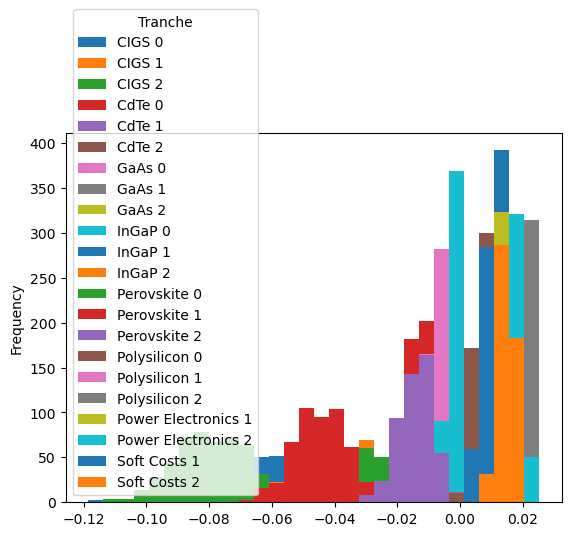

In [13]:
expert_results = tranche_results.metrics[["Value"]].xs(
    "LCOE", level="Index"
).rename(
    columns={"Value" : "LCOE [Δ$/kWh]"}
).unstack(
    ["Tranche"]
).xs("LCOE [Δ$/kWh]", axis=1, drop_level=True).reset_index(drop=True)
expert_results.plot.hist(bins=30)

### Make tornado plots for Expert A.

#### Remember base case LCOE.

In [14]:
base_lcoe = 0.10613269974604357

#### Define the factors.

In [15]:
tornado_factors = [
    "MCC", "MLT", "MEF", "MAP", "MOM",
    "MDR", "ICC", "ILT", "IRC", "IEF",
    "BCC", "BLR", "BPR", "BCA", "BOH",
]

#### Add the scenarios to the design.

In [16]:
designs.parameters

Offset  \
Technology Tranche      Parameter                      
PV Generic CIGS 0       Benchmark LCOC            22   
                        Benchmark LCOE            23   
                        Customer Acquisition      18   
                        Direct Labor              16   
                        Discount Rate              0   
...                                              ...   
           Soft Costs 2 Module Lifetime            4   
                        Module O&M Fixed           7   
                        Module Soiling Loss       10   
                        Permitting                17   
                        System Size                2   

                                                                             Value  \
Technology Tranche      Parameter                                                    
PV Generic CIGS 0       Benchmark LCOC                                     2.51977   
                        Benchmark LCOE                                    0.086773   
                        Customer Acquisition   st.triang(0.5, loc=2000, scale=0.2)   
                        Direct Labor           st.triang(0.5, loc=2000, scale=0.2)   
                        Discount Rate                                         0.07   
...                                                                            ...   
           Soft Costs 2 Module Lifetime       st.triang(0.5, loc=25, scale=0.0025)   
                        Module O&M Fixed       st.triang(0.5, loc=20, scale=0.002)   
                        Module Soiling Loss   st.triang(0.5, loc=0.05, scale=5e-6)   
                        Permitting              st.triang(0.5, loc=400, scale=100)   
                        System Size                                             36   

                                                 Units Notes  
Technology Tranche      Parameter                             
PV Generic CIGS 0       Benchmark LCOC           $/Wdc   NaN  
                        Benchmark LCOE           $/kWh   NaN  
                        Customer Acquisition  $/system   BCA  
                        Direct Labor          $/system   BLR  
                        Discount Rate           1/year    DR  
...                                                ...   ...  
           Soft Costs 2 Module Lifetime             yr   MLT  
                        Module O&M Fixed       $/kW/yr   MOM  
                        Module Soiling Loss      %/100   MSL  
                        Permitting            $/system   BPR  
                        System Size                m^2   SSZ  

[552 rows x 4 columns]

In [17]:
design_2015_actual    = designs.designs.xs   ("CIGS 0", level="Tranche")
parameter_2015_actual = designs.parameters.xs("CIGS 0", level="Tranche")
parameter_expert_a    = designs.parameters.xs("CIGS 1"   , level="Tranche")
for factor in tornado_factors:
    tranche_new = factor
    design_new = design_2015_actual.copy()
    design_new["Tranche"] = tranche_new
    designs.designs = pd.concat([designs.designs,
                                design_new.reset_index().set_index(["Technology", "Tranche", "Variable", "Index"])])
    parameter_new = pd.concat([
        parameter_2015_actual[parameter_2015_actual["Notes"] != factor],
        parameter_expert_a   [parameter_expert_a   ["Notes"] == factor],
    ])
    parameter_new["Tranche"] = factor
    designs.parameters = pd.concat([designs.parameters,
                                   parameter_new.reset_index().set_index(["Technology", "Tranche", "Parameter"])])

#### Recompile the design.

In [18]:
designs.compile()

#### Compute the results.

In [19]:
tranche_results = investments.evaluate_tranches(designs, sample_count=500)
tranche_results.metrics.shape

Evaluating PV Generic


(88002, 2)

#### Make the tornado plot.

In [20]:
tornado_results =tranche_results.metrics[[
    "Value"
]].xs(
    "LCOE", level="Index"
).rename(
    columns={"Value" : "LCOE [$/kWh]"}
).reset_index(
    ["Technology", "Sample"], drop=True
).drop(
    ["CIGS 0", "CIGS 1", "CIGS 2"]
).reset_index(
).sort_values(
    "LCOE [$/kWh]", ascending = False
)
tornado_results["LCOE Reduction [%]"] = 100 * tornado_results["LCOE [$/kWh]"] / 0.106125

In [21]:
pl.figure(figsize=(8, 6), dpi = 300)

<Figure size 2400x1800 with 0 Axes>

<Figure size 2400x1800 with 0 Axes>

In [22]:
sb.set(font_scale = 1)

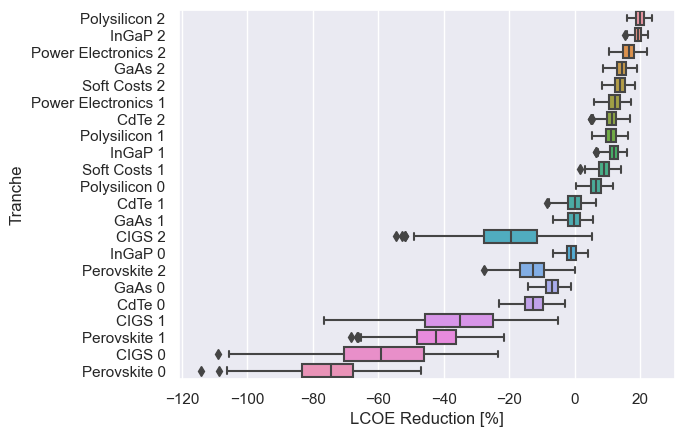

In [23]:
ax = sb.boxplot(
    data = tornado_results,
    y = "Tranche",
    x = "LCOE Reduction [%]"
)
for i,box in enumerate(ax.artists):
    box.set_edgecolor('black')
    box.set_facecolor('none')
    for j in range(6*i,6*(i+1)):
         ax.lines[j].set_color('black')

In [24]:
z = list(ax.get_children())

In [25]:
sb.barplot(
    data = tornado_results.groupby("Tranche").agg(np.mean).reset_index().sort_values(
    "LCOE [$/kWh]", ascending = False,
),
    y = "Tranche",
    x = "LCOE Reduction [%]",
    color = "lightblue",
    ax = ax,
)

C:\Users\rhanes\AppData\Local\Temp\1\ipykernel_24004\2545932593.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = tornado_results.groupby("Tranche").agg(np.mean).reset_index().sort_values(


<AxesSubplot: xlabel='LCOE Reduction [%]', ylabel='Tranche'>

In [26]:
for zi in z:
    zi.set_zorder(1000)

In [27]:
ax.set_xlabel("LCOE Reduction [%]",fontsize=15)
ax.set_ylabel("Tranche",fontsize=15)
ax.tick_params(labelsize=15)

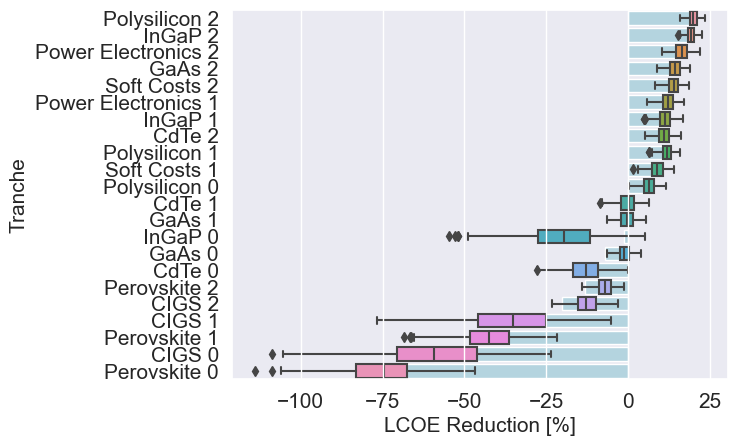

In [28]:
ax.figure

In [29]:
#ax.figure.savefig("pv_residential_validation.png", dpi = 300, bbox_inches = "tight")